# Data Preparation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the assets and their respective portfolio weights
assets = ['AAPL', 'MSFT', 'GOOGL']
portfolio = [0.45, 0.35, 0.20]

# Define the start and end dates for historical data
start_date = "2010-01-01"
end_date = "2017-01-01"
investment = 10000

# Function to read data from the files
def read_data(filename):
    return pd.read_csv(filename, usecols=['Date', 'Close'], parse_dates=['Date'], index_col='Date')

# Dictionary to map asset names to their respective data files
file_mapping = {
    'AAPL': './data/aapl.us.txt',
    'MSFT': './data/msft.us.txt',
    'GOOGL': './data/googl.us.txt'
}

# List to store the dataframes
dfs = []


In [5]:
# Initialize an empty list to store dataframes for each asset
dfs = []

In [6]:
# Download historical data for each asset and append to the dfs list
for asset in assets:
    data = read_data(file_mapping[asset])
    data = data.loc[start_date:end_date]
    dfs.append(data)

# Calculate normalized returns and growth rate for each asset's DataFrame in dfs
for data in dfs:
    data['Norm return'] = data['Close'] / data.iloc[0]['Close']
    data['Growth rate'] = data['Close'].pct_change()
    data['Position'] = data['Norm return'] * investment
    data.dropna(inplace=True)

Let's look at just one stock.

In [7]:
dfs[0]

,Close,Norm return,Growth rate,Position
Date,,,,
2010-01-05,27.454,1.001751,0.001751,10017.514413
2010-01-06,27.017,0.985806,-0.015918,9858.060279
2010-01-07,26.968,0.984018,-0.001814,9840.180982
2010-01-08,27.147,0.990550,0.006637,9905.495147
2010-01-11,26.907,0.981792,-0.008841,9817.923083
...,...,...,...,...
2016-12-23,114.680,4.184485,0.002010,41844.851492
2016-12-27,115.410,4.211122,0.006366,42111.216522
2016-12-28,114.920,4.193242,-0.004246,41932.423557


What do you believe is the most crucial factor in accurately predicting the future position value?

# 6.1 Decision Trees

A **decision tree** is a machine learning model used for classification and regression tasks. It works by splitting data into subsets based on the value of input features, creating a tree-like structure of decisions.

A **decision tree** is made up of the following parts:

* **Root Node**: The top node represents the entire dataset. The best feature to split the data is chosen based on criteria like Gini impurity or entropy for classification, or mean squared error for regression.

* **Internal Nodes**: These nodes represent decisions based on feature values. Each node splits the data into two or more subsets based on the feature's value, creating branches.

* **Leaf Nodes**: The terminal nodes represent the final outcome or prediction. For classification, it's a class label; for regression, it's a continuous value.

* **Splitting Criteria**: The decision of which feature to split on is determined by optimizing a certain criterion, such as minimizing impurity or error in the subsets.

* **Pruning**: To avoid overfitting, trees can be pruned by removing branches that add little predictive power, simplifying the model.

Let's implement our first decision tree.

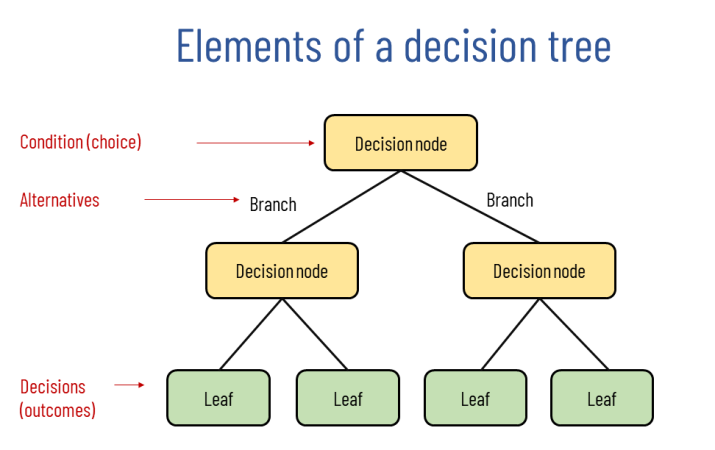

In [8]:
# Long Coding Box

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# Define the label_action function to label actions based on growth rate
def label_action(row):
    if row['Growth rate'] > 0.001:  # Example threshold for investing, buying all those asset that in its previous iteration growth over 0.1%
        return 1  # Invest
    elif row['Growth rate'] < -0.002:  # Example threshold for stop loss, any asset that loses 0.2% of its value the day before
        return -1  # Stop loss
    else:
        return 0  # Hold

In [10]:
# Select the first DataFrame from the list of DataFrames
df = dfs[0]

In [11]:
# Apply the label_action function to each row in the DataFrame
df['Action'] = df.apply(label_action, axis=1)

In [12]:
# Get the first index of the DataFrame
first_index = df.index[0]
df

,Close,Norm return,Growth rate,Position,Action
Date,,,,,
2010-01-05,27.454,1.001751,0.001751,10017.514413,1
2010-01-06,27.017,0.985806,-0.015918,9858.060279,-1
2010-01-07,26.968,0.984018,-0.001814,9840.180982,0
2010-01-08,27.147,0.990550,0.006637,9905.495147,1
2010-01-11,26.907,0.981792,-0.008841,9817.923083,-1
...,...,...,...,...,...
2016-12-23,114.680,4.184485,0.002010,41844.851492,1
2016-12-27,115.410,4.211122,0.006366,42111.216522,1
2016-12-28,114.920,4.193242,-0.004246,41932.423557,-1


In [13]:
# Set the Growth rate of the first index to 0 (normalizing for better comparison)
df.at[first_index, 'Growth rate'] = 0
df.head()

,Close,Norm return,Growth rate,Position,Action
Date,,,,,
2010-01-05,27.454,1.001751,0.000000,10017.514413,1
2010-01-06,27.017,0.985806,-0.015918,9858.060279,-1
2010-01-07,26.968,0.984018,-0.001814,9840.180982,0
2010-01-08,27.147,0.990550,0.006637,9905.495147,1
2010-01-11,26.907,0.981792,-0.008841,9817.923083,-1


In [15]:
print(df.columns)

Index(['Close', 'Norm return', 'Growth rate', 'Position', 'Action'], dtype='object')


In [16]:
# Define the features and target variable for the decision tree
features = ['Close', 'Norm return', 'Growth rate', 'Position']
X = df[features]
Y = df['Action']


In [17]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [19]:
# Make predictions on the test set
Y_pred = clf.predict(X_test)

### How do we evaluate the model?

##### Confusion Matrix
A confusion matrix is a table used to evaluate the performance of a classification algorithm. It provides a summary of prediction results on a classification problem. The matrix compares the actual target values with those predicted by the model. It shows the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions.

* **True Positives (TP)**: The number of instances correctly predicted as positive.
* **True Negatives (TN)**: The number of instances correctly predicted as negative.
* **False Positives (FP)**: The number of instances incorrectly predicted as positive (also known as Type I error).
* **False Negatives (FN)**: The number of instances incorrectly predicted as negative (also known as Type II error).

##### Classification Report
A classification report is a detailed performance evaluation of the classification algorithm. It includes several important metrics:

* **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
  $Precision = \frac{TP}{TP+RP}$

* **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all observations in the actual class.
   $Recall = \frac{TP}{TP+FN}$

* **F1-Score**: The weighted average of Precision and Recall. The F1 score reaches its best value at 1 and worst score at 0.
  $F1 = 2\frac{Precision * Recall}{Precision+Recall}$

In [20]:
# Evaluate the model
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred))
print("\nReport: ")
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[152   0   0]
 [  0  27   0]
 [  0   0 174]]

Report: 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       152
           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00       174

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



In this case, it is evident that the model is **overfitted**, as indicated by the perfect scores across all metrics. Overfitting occurs when a statistical model or machine learning algorithm captures noise or random fluctuations in the training data rather than the underlying pattern.

Why is this the case?
First, let's analyze our prediction goal. We aim to determine whether to buy or sell based on the growth rate. If the growth rate exceeds a certain threshold, we sell; otherwise, we buy.

Now, let's examine the variables we are using to make this prediction. Our dataset includes variables such as volume, return, high, low, etc. However, it also includes the growth rate itself, which is the target variable we are trying to predict.

This means we are inadvertently using the target variable to predict itself, leading to overfitting. To address this, we need to remove the growth rate from our training and test data, ensuring that our model learns from other variables without relying on the target variable directly.

In [22]:
# Long Coding Box

# Define the features and target variable for the decision tree, NOTICE HOW WE REMOVE GROWTH RATE
features = ['Close', 'Norm return', 'Growth rate', 'Position']
X = df[features]
Y = df['Action']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = clf.predict(X_test)

dec_tree_confusion = confusion_matrix(Y_test, Y_pred)
dec_tree_report = classification_report(Y_test, Y_pred)
# Evaluate the model
print("Confusion Matrix: ")
print(dec_tree_confusion)
print("\nReport: ")
print(dec_tree_report)

Confusion Matrix: 
[[152   0   0]
 [  0  27   0]
 [  0   0 174]]

Report: 
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       152
           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00       174

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



####Overall Performance:

The model is performing moderately well overall, particularly in classifying classes -1 and 1. However, it struggles with class 0.

The overall accuracy is 0.6 (weighted avg), which is moderate. The precision, recall, and F1-score for class 0 are very low, indicating significant issues with correctly identifying this class.

#### Confusion Matrix:

>The model correctly classified:

>>68 instances of class -1

>>0 instance of class 0

>>80 instances of class 1

>There are several misclassifications:

>>4 instances of class -1 were misclassified as class 0.

>>43 instances of class -1 were misclassified as class 1.

>>4 instances of class 0 were misclassified as class -1.

>>4 instances of class 0 were misclassified as class 1.

>>49 instances of class 1 were misclassified as class -1.

>>3 instances of class 1 were misclassified as class 0.

####Classification Report:

Precision, Recall, and F1-score are key metrics for evaluating the performance of the model for each class.

>Class -1:

>>Precision: 0.56, meaning 56% of instances predicted as class -1 were actually class -1.

>>Recall: 0.61, meaning the model correctly identified 61% of the actual class -1 instances.

>>F1-score: 0.58, indicating a decent balance between precision and recall for this class.

>Class 0:

>>Precision: 0.00, meaning only 0% of instances predicted as class 0 were actually class 0.

>>Recall: 0.00, meaning the model correctly identified 0% of the actual class 0 instances.

>>F1-score: 0.00, indicating poor performance in classifying class 0.

>Class 1:

>>Precision: 0.63, meaning 63% of instances predicted as class 1 were actually class 1.

>>Recall: 0.61, meaning the model correctly identified 61% of the actual class 1 instances.

>>F1-score: 0.62, indicating a good balance between precision and recall for this class.

#### Macro Average and Weighted Average scores provide a more general view of the model performance across all classes.

>Macro Average:

>>Precision: 0.40

>>Recall: 0.40

>>F1-score: 0.40

These scores are the average performance across all classes without taking class imbalance into account.

>Weighted Average:

>>Precision: 0.58

>>Recall: 0.59

>>F1-score: 0.58

These scores consider the support (the number of true instances for each class) to provide a more balanced evaluation based on class frequency.

####Interpretation:

The model performs moderately well for classes -1 and 1, with reasonable precision, recall, and F1-scores, indicating that it correctly identifies and classifies most instances of these classes. However, it struggles significantly with class 0. The precision and recall for class 0 are very low, leading to poor F1-scores. The overall moderate accuracy is driven by the model's ability to handle the majority classes (-1 and 1), but this hides the poor performance on the minority class (0). This imbalance suggests that while the model is good at detecting the majority classes, it needs improvement in detecting and correctly classifying the minority class.

#### Now let's visualize the results

Now, since the variable we are going to classify is Action, it makes little to no sense to include it in the model. Additionally, since Position is completely independent of the dynamics of the data, we can also exclude it and calculate it later. Remember, we should also exclude Growth rate from the model.

In [23]:
# Generate predictions using the trained classifier
# predictions = clf.predict(df.drop(['Action', 'Position', 'Growth rate'], axis=1))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Growth rate
- Position


In [25]:
# Generate predictions using the trained classifier
# Ensure the features used for prediction match those used during training

# Define the features used during training
features = [f'{asset}_Open' for asset in assets] + [f'{asset}_High' for asset in assets] + \
           [f'{asset}_Low' for asset in assets] + [f'{asset}_Close' for asset in assets] + \
           [f'{asset}_Adj Close' for asset in assets] + [f'{asset}_Volume' for asset in assets] + \
           [f'{asset}_Norm return' for asset in assets]

# Select the relevant features for prediction
X_predict = combined_df[features]

# Generate predictions
predictions = clf.predict(X_predict)

print(predictions)


NameError: name 'combined_df' is not defined

In [24]:
# Long Coding Box

# Define the Model_invest function to simulate investment decisions based on predictions
def Model_invest(predictions, investment):
    ivs = [investment]  # Initialize a list to store investment values over time
    left = [0]  # Initialize a list to store leftover values over time

    # Iterate through predictions starting from the second element
    for k, p in enumerate(predictions[1:]):
        growth = df['Growth rate'][k] # Get the growth rate for the current step
        current_investment = ivs[-1] + (ivs[-1] * growth)  # Calculate the current investment value
        current_left = left[-1]  # Get the current leftover value

        if p == 1:  # If the prediction is to invest
            if current_left == 0:
              pass
            new_investment = current_investment + current_left  # Add leftover to investment
            ivs.append(new_investment)  # Update the investment list
            left.append(0)  # Reset the leftover list

        elif p == -1:  # If the prediction is to stop loss
            new_left = current_investment*0.25 + left[-1]  # Add current investment to leftover
            new_investment = current_investment*0.75 # Change the investment to represent the sell

            ivs.append(new_investment)  # Update the investment list
            left.append(new_left)  # Update the leftover list

        else:  # If the prediction is to Hold
            ivs.append(current_investment)  # Keep the investment unchanged
            left.append(current_left)  # Keep the leftover unchanged

    # Return a list of tuples with investment and leftover values
    return list(zip(ivs, left))

Training data:
              AAPL                                    MSFT                  \
              Open    High     Low   Close OpenInt    Open    High     Low   
Date                                                                         
2005-01-03  4.1529  4.1685  4.0083  4.0519       0  22.475  22.601  22.347   
2005-01-04  4.0825  4.1915  4.0314  4.0940       0  22.425  22.727  22.355   
2005-01-05  4.0940  4.1775  4.0940  4.1300       0  22.489  22.727  22.441   
2005-01-06  4.1491  4.1556  4.0545  4.1324       0  22.496  22.692  22.340   
2005-01-07  4.1646  4.4578  4.1469  4.4336       0  22.506  22.550  22.324   

                              GOOGL                                    
             Close OpenInt     Open     High     Low    Close OpenInt  
Date                                                                   
2005-01-03  22.425       0   98.700  101.820  97.730  101.360       0  
2005-01-04  22.506       0  100.700  101.460  96.740   97.250       0  


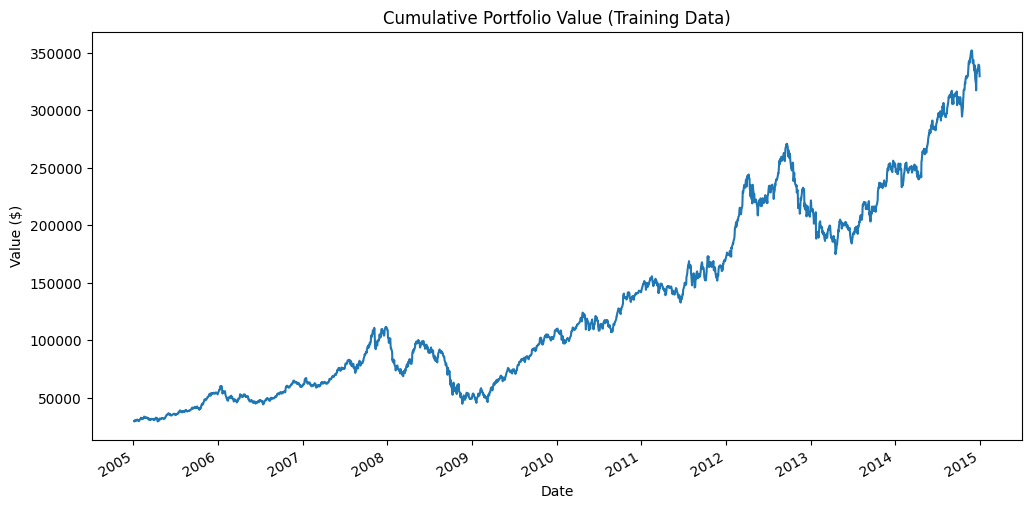

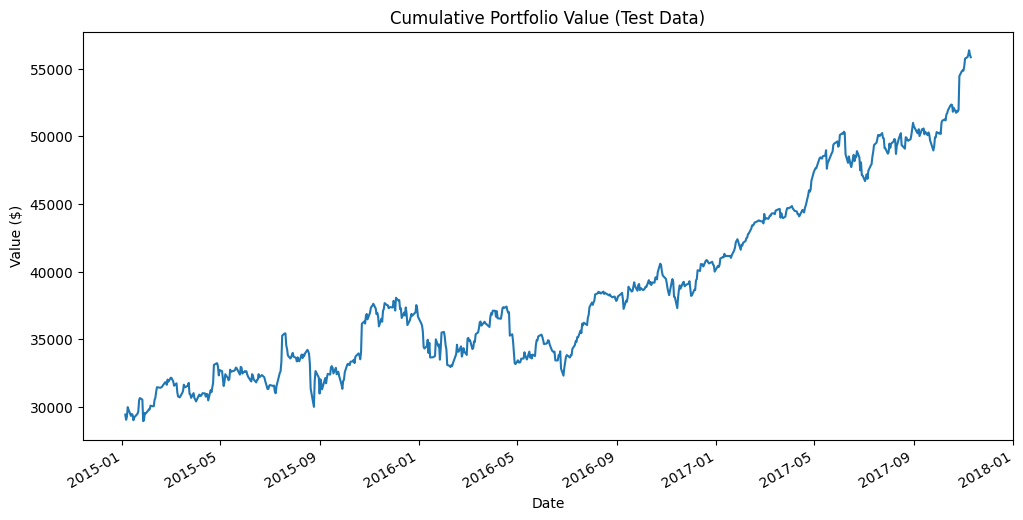

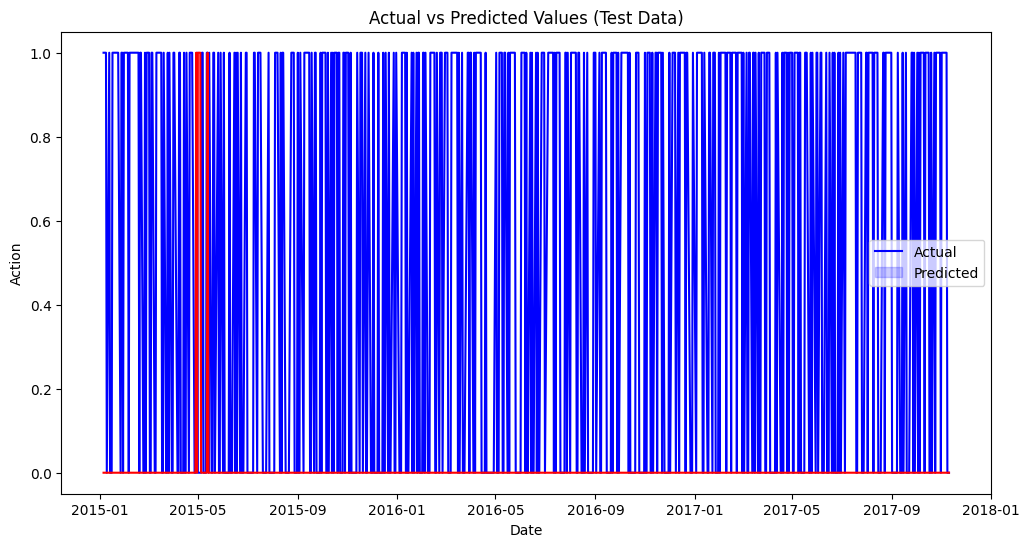

In [36]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Define the assets and their respective portfolio weights
assets = ['AAPL', 'MSFT', 'GOOGL']
portfolio = [0.45, 0.35, 0.20]

# Define the start and end dates for historical data
start_date_train = "2005-01-01"
end_date_train = "2014-12-31"
start_date_test = "2015-01-01"
end_date_test = "2017-12-31"
investment = 10000

# Function to read data from the files
def read_data(filename):
    return pd.read_csv(filename, usecols=['Date', 'Open', 'High', 'Low', 'Close', 'OpenInt'], parse_dates=['Date'], index_col='Date')

# Dictionary to map asset names to their respective data files
file_mapping = {
    'AAPL': './data/aapl.us.txt',
    'MSFT': './data/msft.us.txt',
    'GOOGL': './data/googl.us.txt'
}

# List to store the dataframes
dfs_train = []
dfs_test = []

# Read and split data for each asset
for asset in assets:
    data = read_data(file_mapping[asset])
    data_train = data.loc[start_date_train:end_date_train]
    data_test = data.loc[start_date_test:end_date_test]
    if data_train.empty or data_test.empty:
        print(f"No data found for {asset} in the specified date range.")
        continue
    dfs_train.append(data_train)
    dfs_test.append(data_test)

# Concatenate all dataframes for training and testing
if not dfs_train or not dfs_test:
    raise ValueError("No data available for any assets in the specified date range.")

combined_df_train = pd.concat(dfs_train, axis=1, keys=assets)
combined_df_test = pd.concat(dfs_test, axis=1, keys=assets)

# Check the dataframes before further processing
print("Training data:")
print(combined_df_train.head())
print("Test data:")
print(combined_df_test.head())

# Calculate normalized returns and growth rate for each asset's DataFrame
for asset in assets:
    combined_df_train[(asset, 'Norm return')] = combined_df_train[(asset, 'Close')] / combined_df_train[(asset, 'Close')].iloc[0]
    combined_df_train[(asset, 'Growth rate')] = combined_df_train[(asset, 'Close')].pct_change()
    combined_df_train[(asset, 'Position')] = combined_df_train[(asset, 'Norm return')] * investment
    combined_df_test[(asset, 'Norm return')] = combined_df_test[(asset, 'Close')] / combined_df_test[(asset, 'Close')].iloc[0]
    combined_df_test[(asset, 'Growth rate')] = combined_df_test[(asset, 'Close')].pct_change()
    combined_df_test[(asset, 'Position')] = combined_df_test[(asset, 'Norm return')] * investment

# Drop rows with NaN values, but first check the amount of NaN values
print("NaN values in training data before dropna:")
print(combined_df_train.isna().sum())
print("NaN values in test data before dropna:")
print(combined_df_test.isna().sum())

combined_df_train.dropna(inplace=True)
combined_df_test.dropna(inplace=True)

# Check the dataframes after dropping NaN values
print("Training data after dropna:")
print(combined_df_train.head())
print("Test data after dropna:")
print(combined_df_test.head())

# Flatten the multi-index columns
combined_df_train.columns = ['_'.join(col).strip() for col in combined_df_train.columns.values]
combined_df_test.columns = ['_'.join(col).strip() for col in combined_df_test.columns.values]

# Define the features and target variable for the decision tree
features = [f'{asset}_Open' for asset in assets] + [f'{asset}_High' for asset in assets] + \
           [f'{asset}_Low' for asset in assets] + [f'{asset}_Close' for asset in assets] + \
           [f'{asset}_OpenInt' for asset in assets] + [f'{asset}_Norm return' for asset in assets]

# Define the Action variable based on specific conditions
combined_df_train['Action'] = (combined_df_train['AAPL_Close'].shift(-1) > combined_df_train['AAPL_Close']).astype(int)
combined_df_test['Action'] = (combined_df_test['AAPL_Close'].shift(-1) > combined_df_test['AAPL_Close']).astype(int)

# Remove rows where the Action column is NaN
combined_df_train.dropna(subset=['Action'], inplace=True)
combined_df_test.dropna(subset=['Action'], inplace=True)

# Check the target variable
print("Training target variable distribution:")
print(combined_df_train['Action'].value_counts())
print("Test target variable distribution:")
print(combined_df_test['Action'].value_counts())

X_train = combined_df_train[features]
Y_train = combined_df_train['Action']
X_test = combined_df_test[features]
Y_test = combined_df_test['Action']

# Initialize and fit the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

# Print the feature importances
print("Feature importances:", clf.feature_importances_)

# Generate predictions using the trained classifier
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(Y_test, predictions))

# Calculate and print the Mean Squared Error
mse = mean_squared_error(Y_test, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Plot the cumulative portfolio value for training data
portfolio_value_train = combined_df_train[[col for col in combined_df_train.columns if 'Position' in col]].sum(axis=1)
plt.figure(figsize=(12, 6))
portfolio_value_train.plot()
plt.title('Cumulative Portfolio Value (Training Data)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.show()

# Plot the cumulative portfolio value for test data
portfolio_value_test = combined_df_test[[col for col in combined_df_test.columns if 'Position' in col]].sum(axis=1)
plt.figure(figsize=(12, 6))
portfolio_value_test.plot()
plt.title('Cumulative Portfolio Value (Test Data)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.show()

# Create a DataFrame to hold the actual and predicted values
results_df = pd.DataFrame({'Date': Y_test.index, 'Actual': Y_test, 'Predicted': predictions})
results_df.set_index('Date', inplace=True)

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, palette=["blue", "red"], dashes=False)
plt.title('Actual vs Predicted Values (Test Data)')
plt.xlabel('Date')
plt.ylabel('Action')
plt.legend(['Actual', 'Predicted'])
plt.show()
